# Análise Exploratória dos Dados da Base MIMIC-III

O MIMIC (Medical Information Mart for Intensive Care) é um grande banco de dados disponível gratuitamente que inclui dados relacionados à saúde não identificados de pacientes que foram admitidos nas unidades de cuidados intensivos do Beth Israel Deaconess Medical Center.

O MIMIC é composto por dados coletados de dois sistemas de informações clínicas diferentes: CareVue e MetaVision.

Nesta versão da base MIMIC temos atendimentos efetuados de **01/06/2001** a **10/10/2012**.

Número de atendimentos: **58.976**

Número de pacientes atendidos: **46.520**

## Objetivo

Compreender as principais características da base do MIMIC-III, que é uma base muito relevante para estudo de doenças e criação de modelos. A partir da análise exploratória, será possível entender a natureza dos dados aqui presentes e de que formas ela pode ser útil em estudos futuros, como na própria dissertação.

## Resultados

Imports das bibliotecas

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

### Pacientes

Número de pacientes

In [88]:
patients_df = pd.read_csv('C:\csvMimic\\v1_4\PATIENTS.csv', usecols=['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG'])
tam_patients  = patients_df.shape[0]
tam_patients

46520

Número de pacientes por gênero

F    20399
M    26121
Name: GENDER, dtype: int64


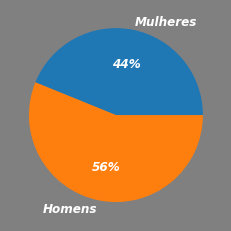

In [89]:
print(patients_df['GENDER'].value_counts(ascending=True, normalize=False))
plt.figure(facecolor='grey')
plt.pie(patients_df['GENDER'].value_counts(ascending=True), labels = ['Mulheres', 'Homens'], autopct='%.0f%%', textprops={'fontsize': 12, 'color': 'white', 'style': 'oblique', 'weight': 'bold'})
plt.show()

Temos que a quantidade de homens e mulheres é próxima, sem grande disparidade.

Qual a taxa de sobrevivência destes pacientes?

In [90]:
survival_total = pd.DataFrame(data=patients_df['EXPIRE_FLAG'].value_counts(ascending=True).reset_index(name='total'))
survival_total['percentual'] = (survival_total['total'] / tam_patients * 100).round(2)
survival_total.rename(columns={'index': 'morreu'}, inplace=True)
survival_total.loc[survival_total['morreu'] == 0, 'morreu'] = 'não'
survival_total.loc[survival_total['morreu'] == 1, 'morreu'] = 'sim'
survival_total

,morreu,total,percentual
0,sim,15759,33.88
1,não,30761,66.12


In [91]:
survival_total_by_gender = patients_df.groupby('EXPIRE_FLAG')['GENDER'].value_counts().reset_index(name='total')
survival_total_by_gender['percentual'] = (survival_total_by_gender['total'] / tam_patients * 100).round(2)
gs_df = pd.DataFrame(data=survival_total_by_gender)
gs_df.rename(columns={'EXPIRE_FLAG': 'morreu', 'GENDER': 'gênero'}, inplace=True)
gs_df.loc[gs_df['morreu'] == 0, 'morreu'] = 'não'
gs_df.loc[gs_df['morreu'] == 1, 'morreu'] = 'sim'
gs_df

,morreu,gênero,total,percentual
0,não,M,17597,37.83
1,não,F,13164,28.30
2,sim,M,8524,18.32
3,sim,F,7235,15.55


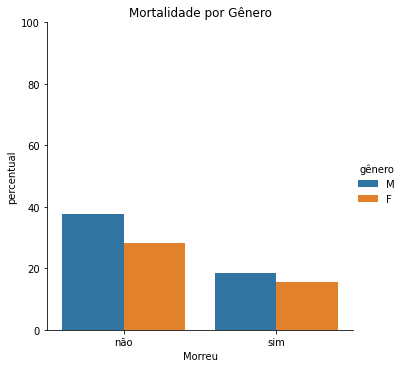

In [92]:
ax = sns.catplot(data=gs_df, x='morreu', y='percentual', kind='bar', hue='gênero')
ax.set(title ="Mortalidade por Gênero", xlabel='Morreu', ylim=(0,100))
ax

A maioria dos pacientes sobrevive e dentre eles os homens são maioria.

**Pergunta:** Essas taxas de sobrevivência são confiáveis? Qual a idade destes pacientes?

Distribuição dos pacientes por idade

Os pacientes foram divididos em 3 grupos etários:
- Com idade de 0 a 1 ano : *neonate*
- Com idade acima entre 14 e 89 anos: *adult*
- Acima de 89 anos: *>89*

Observação: Não foram realizados atendimentos em indivíduos entre 2 e 13 anos, por isso estas idades não são contempladas por nenhuma faixa.

Todas as datas na base incluindo a data de nascimento dos pacientes foi alterada para datas randômicas (no passado e no futuro) para resguardar a privacidade das pessoas envolvidas. Para se obter a idade foi efetuado o cálculo via query SQL da diferença entre a data de nascimento e a data do primeiro atendimento do paciente.

In [93]:
patients_by_age = pd.read_csv('C:\csvMimic\\pacientes-por-idades-2.csv')
patients_by_age.head()

,subject_id,dob,gender,first_admittime,first_admit_age,expire_flag,age_group
0,2,2138-07-17 00:00:00,M,2138-07-17 19:04:00,0.00,0,neonate
1,3,2025-04-11 00:00:00,M,2101-10-20 19:08:00,76.52,1,adult
2,4,2143-05-12 00:00:00,F,2191-03-16 00:28:00,47.84,0,adult
3,5,2103-02-02 00:00:00,M,2103-02-02 04:31:00,0.00,0,neonate
4,6,2109-06-21 00:00:00,F,2175-05-30 07:15:00,65.94,0,adult


Verificando as estatísticas do atributo idade

In [94]:
patients_by_age['first_admit_age'].describe()

count    46520.000000
mean        61.878247
std         57.456175
min          0.000000
25%         38.530000
50%         60.490000
75%         75.510000
max        300.000000
Name: first_admit_age, dtype: float64

Os pacientes com idade superior a 89 anos tiveram a idade alterada para 300 na base do MIMIC-III. No site da base é informado que estes pacientes que tiveram a sua idade alterada para 300 anos tinham média de idade de 91.4. Portanto, calculando a média de idade dos demais pacientes de forma apartada é possível chegarmos à real média de idade dos pacientes atendidos.

In [95]:
neonate_df = patients_by_age.query('first_admit_age < 1')
adults_df = patients_by_age.query('first_admit_age > 1 and first_admit_age < 90')
elderly_df = patients_by_age.query('first_admit_age == 300')

neonate_mean = neonate_df['first_admit_age'].mean()
adults_mean = adults_df['first_admit_age'].mean()
elderly_mean = 91.4

total_mean = ((neonate_mean + adults_mean + elderly_mean)/3).round(2)
no_neonate_mean = ((adults_mean + elderly_mean)/2).round(2)
print('Média total da idade dos pacientes:', total_mean)
print('Média total da idade dos pacientes excluindo recém-nascidos:', no_neonate_mean)

Média total da idade dos pacientes: 51.21
Média total da idade dos pacientes excluindo recém-nascidos: 76.82


Histograma da idade dos pacientes

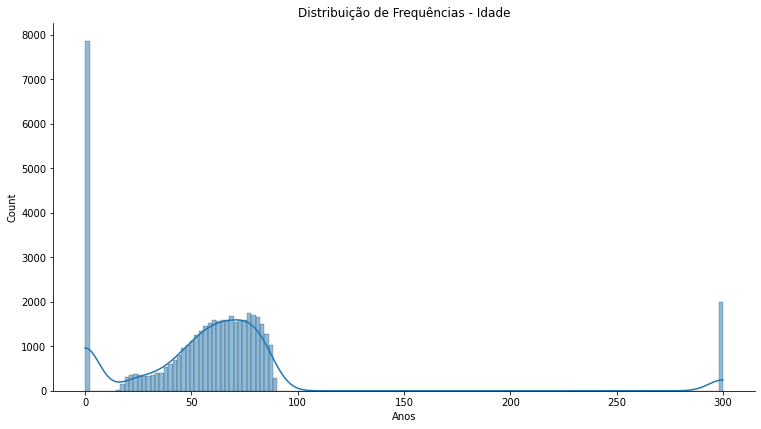

In [96]:
ax = sns.displot(patients_by_age.first_admit_age, kde = True)
ax.figure.set_size_inches(12,6)
ax.set(title ="Distribuição de Frequências - Idade", xlabel='Anos')
ax

Pelo histograma acima a presença de três grupos etários se torna ainda mais evidente. Abaixo, apenas para fins de comprovação, não temos na base pacientes com idade entre 2 e 13 anos.

In [97]:
patients_by_age.query('first_admit_age > 1 and first_admit_age < 14')

,subject_id,dob,gender,first_admittime,first_admit_age,expire_flag,age_group


Distribuição de idade entre os adultos

<AxesSubplot:title={'center':'Distribuição de Frequências - Idade Adulta'}, xlabel='Anos', ylabel='Count'>

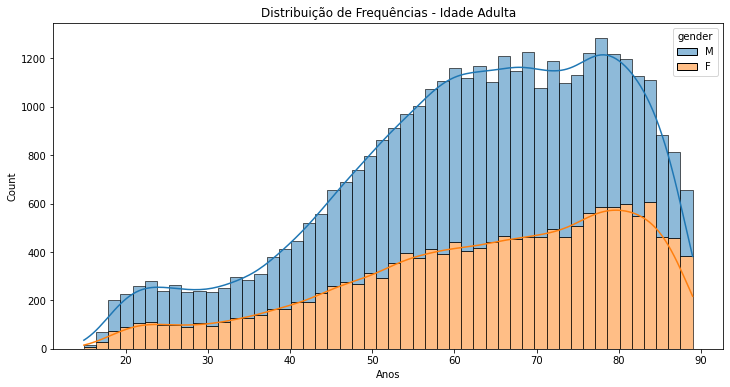

In [98]:
ax = sns.histplot(data=adults_df, x='first_admit_age', kde = True, hue='gender', multiple="stack")
ax.figure.set_size_inches(12,6) 
ax.set(title ="Distribuição de Frequências - Idade Adulta", xlabel='Anos')
ax

O intervalo de idades na faixa adulta é muito grande. Vamos plotar um boxplot das idades desta faixa para verificar mais claramente em que intervalo de idades estão concentrados a maior parte dos atendimentos.

<AxesSubplot:title={'center':'Idade - Grupo Adulto'}, xlabel='Anos', ylabel='Sexo'>

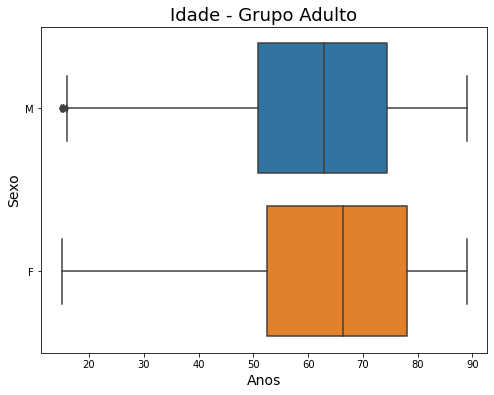

In [99]:
ax = sns.boxplot(x = 'first_admit_age', y='gender', data=adults_df)
ax.figure.set_size_inches(8,6)
ax.set_title('Idade - Grupo Adulto', fontsize=18)
ax.set_xlabel('Anos', fontsize=14)
ax.set_ylabel('Sexo', fontsize=14)
ax

Taxa de mortalidade por grupo etário

In [100]:
tam = patients_by_age.shape[0]
# patients_age_gender_mortality = patients_by_age.groupby(['expire_flag', 'age_group', 'gender'], as_index=False).agg('count')

patients_age_gender_mortality = patients_by_age.groupby(['expire_flag', 'age_group'])['gender'].value_counts().reset_index(name='total')
patients_age_gender_mortality['percentual'] = (patients_age_gender_mortality['total'] / tam * 100).round(2)
patients_age_gender_mortality.rename(columns={'expire_flag': 'morreu', 'gender': 'gênero', 'age_group': 'faixa etária'}, inplace=True)
patients_age_gender_mortality

,morreu,faixa etária,gênero,total,percentual
0,0,>89,F,356,0.77
1,0,>89,M,155,0.33
2,0,adult,M,13235,28.45
3,0,adult,F,9207,19.79
4,0,neonate,M,4207,9.04
5,0,neonate,F,3601,7.74
6,1,>89,F,938,2.02
7,1,>89,M,542,1.17
8,1,adult,M,7944,17.08
9,1,adult,F,6269,13.48


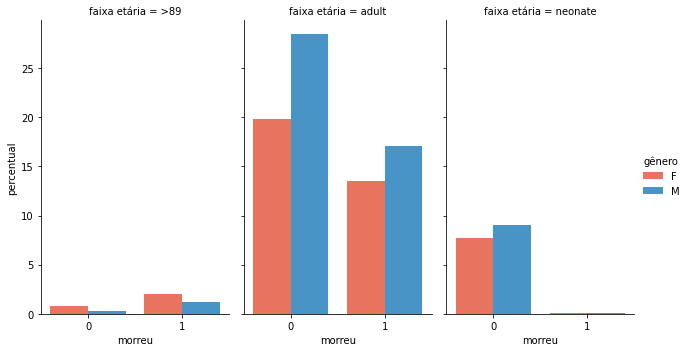

In [101]:
ax = sns.catplot(data=patients_age_gender_mortality, x='morreu', y='percentual', kind='bar', hue='gênero', col='faixa etária', aspect=.6, palette=dict(F="tomato", M="#3498db"))
ax

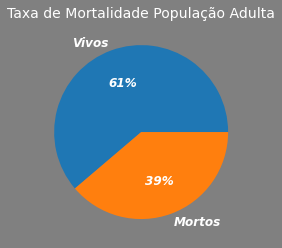

In [102]:
plt.figure(facecolor='grey')
plt.pie(adults_df['expire_flag'].value_counts(), autopct='%.0f%%', labels = ['Vivos', 'Mortos'], textprops={'fontsize': 12, 'color': 'white', 'style': 'oblique', 'weight': 'bold'})
plt.title('Taxa de Mortalidade População Adulta', color='white', fontsize=14)
plt.show()

### Atendimentos

Número de atendimentos

In [103]:
main_admission_cols = [
    'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME',
    'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',
    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME',
    'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG']

admissions_df = pd.read_csv('C:\csvMimic\\v1_4\ADMISSIONS.csv', usecols = main_admission_cols)
tam_admissions  = admissions_df.shape[0]
tam_admissions

58976

Quantidade de atendimentos por paciente

In [104]:
qtde_adm_patients = pd.read_csv('C:\csvMimic\\atendimentos-por-qtde-pacientes.csv')
print("Número de pacientes com um único atendimento: ", qtde_adm_patients.cont[0])
print("Número de pacientes com mais de um atendimento: ", qtde_adm_patients['cont'].sum() - qtde_adm_patients.cont[0])

Número de pacientes com um único atendimento:  38983
Número de pacientes com mais de um atendimento:  7537


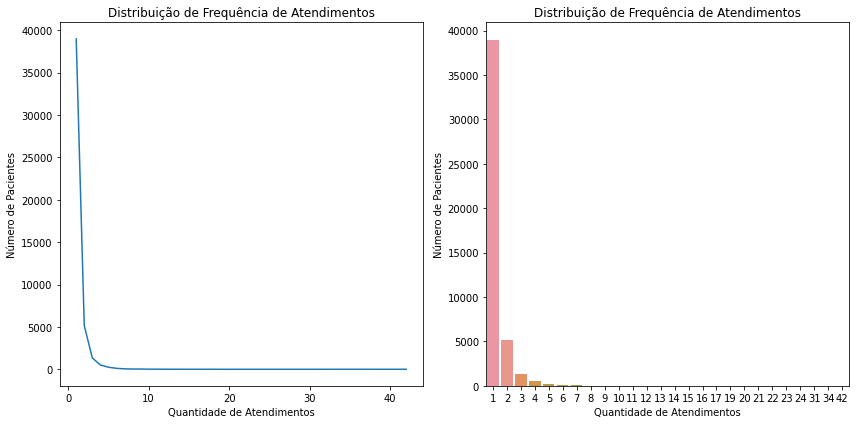

In [105]:
f, axs = plt.subplots(1, 2, figsize=(12, 6)) #gridspec_kw=dict(width_ratios=[4, 3])
sns.lineplot(data=qtde_adm_patients,  x='qtd_adm', y='cont', ax=axs[0])
sns.barplot(data=qtde_adm_patients,  x='qtd_adm', y='cont', ax=axs[1])
axs[0].set(title ="Distribuição de Frequência de Atendimentos", xlabel='Quantidade de Atendimentos', ylabel = 'Número de Pacientes')
axs[1].set(title ="Distribuição de Frequência de Atendimentos", xlabel='Quantidade de Atendimentos', ylabel = 'Número de Pacientes')
f.tight_layout()

Tipos de Atendimento

Temos na base 4 tipos possíveis de tipos de atendimento. São eles:
- emergency: Atendimentos não planejados
- urgent: Atendimentos não planejados
- elective: Atendimentos planejados
- newborn: Nascimentos

Os mantenedores do MIMIC-III indicam que as categorias *emergency* e *urgent* podem ser agrupadas, por terem a mesma natureza.

(0.0, 58976.0)

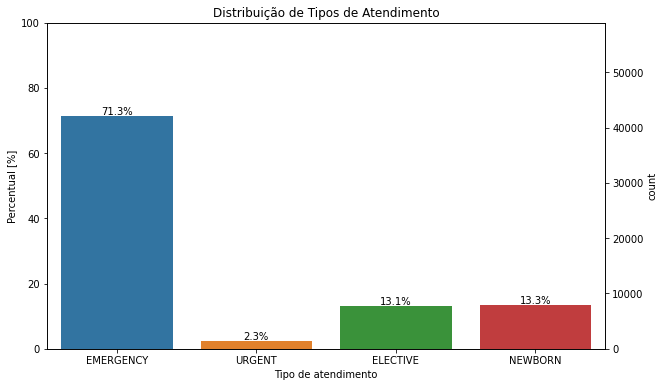

In [106]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="ADMISSION_TYPE", data=admissions_df, order=['EMERGENCY', 'URGENT', 'ELECTIVE', 'NEWBORN'])
plt.title('Distribuição de Tipos de Atendimento')
plt.xlabel('Tipo de atendimento')

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('Percentual [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_admissions), (x.mean(), y), ha='center', va='bottom')
ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_admissions)

#### Duração dos atendimentos

Verificando se temos valores nulos nas datas

In [107]:
print(admissions_df.isnull().values.any())
nan_columns = admissions_df.isna().any()
admissions_df.columns[nan_columns].tolist()

True


['DEATHTIME',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'EDREGTIME',
 'EDOUTTIME',
 'DIAGNOSIS']

Dado que não temos dados faltantes, vamos calcular a duração de cada atendimento em dias

In [108]:
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'])

admissions_df['duration'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME']).dt.days

Duração média dos atendimentos

In [109]:
admissions_df.duration.describe()

count    58976.000000
mean         9.610672
std         12.452546
min         -1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max        294.000000
Name: duration, dtype: float64

<AxesSubplot:title={'center':'Boxplot - Duração de Atendimentos'}, xlabel='Dias'>

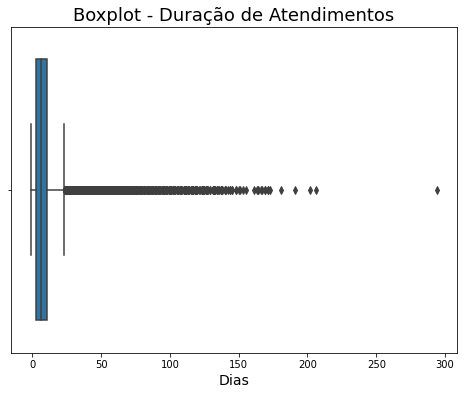

In [110]:
ax = sns.boxplot(x = 'duration', data=admissions_df, orient='h')
ax.figure.set_size_inches(8,6)
ax.set_title('Boxplot - Duração de Atendimentos', fontsize=18)
ax.set_xlabel('Dias', fontsize=14)
ax

<AxesSubplot:title={'center':'Boxplot - Duração de Atendimentos'}, xlabel='Dias', ylabel='Mortalidade'>

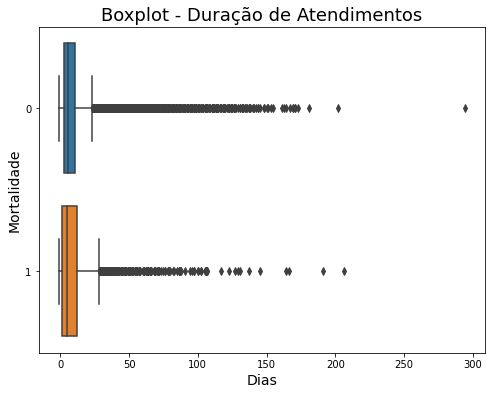

In [111]:
ax = sns.boxplot(x = 'duration', y='HOSPITAL_EXPIRE_FLAG', data=admissions_df, orient='h')
ax.figure.set_size_inches(8,6)
ax.set_title('Boxplot - Duração de Atendimentos', fontsize=18)
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Mortalidade', fontsize=14)
ax

Duração de atendimento na emergência

In [112]:
aux = admissions_df.copy()
print("Quantidade de registros original: ", aux.shape[0])
aux = aux.dropna()
print("Quantidade de registros após remoção de atendimentos sem estadia na emergência : ", aux.shape[0])

Quantidade de registros original:  58976
Quantidade de registros após remoção de atendimentos sem estadia na emergência :  2053


In [113]:
aux['EDREGTIME'] = pd.to_datetime(aux['EDREGTIME'])
aux['EDOUTTIME'] = pd.to_datetime(aux['EDOUTTIME'])

aux['duration_em'] = (aux['EDOUTTIME'] - aux['EDREGTIME']).dt.seconds
aux['duration_em'] = aux['duration_em'] /3600 # convertendo segundos em horas
print(aux.duration_em.describe())

count    2053.000000
mean        5.061560
std         2.657447
min         0.066667
25%         3.283333
50%         4.600000
75%         6.250000
max        23.383333
Name: duration_em, dtype: float64


## Serviços

In [114]:
services_df = pd.read_csv('C:\csvMimic\\v1_4\SERVICES.csv')
tam_services = services_df.shape[0]
tam_services

73343

In [115]:
serv_types_dict = {
    'CMED':	   'Cardiac Medical - for non-surgical cardiac related admissions',
    'CSURG':   'Cardiac Surgery - for surgical cardiac admissions',
    'DENT':	   'Dental - for dental/jaw related admissions',
    'ENT':     'Ear, nose, and throat - conditions primarily affecting these areas',
    'GU':      'Genitourinary - reproductive organs/urinary system',
    'GYN':	   'Gynecological - female reproductive systems and breasts',
    'MED':	   'Medical - general service for internal medicine',
    'NB':	   'Newborn - infants born at the hospital',
    'NBB':	   'Newborn baby - infants born at the hospital',
    'NMED':	   'Neurologic Medical - non-surgical, relating to the brain',
    'NSURG':   'Neurologic Surgical - surgical, relating to the brain',
    'OBS':	   'Obstetrics - conerned with childbirth and the care of women giving birth',
    'ORTHO':   'Orthopaedic - surgical, relating to the musculoskeletal system',
    'OMED':	   'Orthopaedic medicine - non-surgical, relating to musculoskeletal system',
    'PSURG':   'Plastic - restortation/reconstruction of the human body (including cosmetic or aesthetic)',
    'PSYCH':   'Psychiatric - mental disorders relating to mood, behaviour, cognition, or perceptions',
    'SURG':	   'Surgical - general surgical service not classified elsewhere',
    'TRAUM':   'Trauma - injury or damage caused by physical harm from an external source',
    'TSURG':   'Thoracic Surgical - surgery on the thorax, located between the neck and the abdomen',
    'VSURG':   'Vascular Surgical - surgery relating to the circulatory system'
}

In [116]:
aux = services_df.copy()
serv_types = aux['CURR_SERVICE'].value_counts().rename_axis('unique_values').reset_index(name='counts')
serv_types.columns

Index(['unique_values', 'counts'], dtype='object')

In [117]:
aux = services_df.copy()
serv_types = aux['CURR_SERVICE'].value_counts().rename_axis('unique_values').reset_index(name='counts')
serv_types['desc'] = serv_types.apply(lambda x: serv_types_dict.get(x['unique_values']), axis=1)
serv_types

,unique_values,counts,desc
0,MED,24866,Medical - general service for internal medicine
1,CMED,9135,Cardiac Medical - for non-surgical cardiac rel...
2,CSURG,7911,Cardiac Surgery - for surgical cardiac admissions
3,NB,7806,Newborn - infants born at the hospital
4,SURG,5514,Surgical - general surgical service not classi...
5,NSURG,4100,"Neurologic Surgical - surgical, relating to th..."
6,TRAUM,3137,Trauma - injury or damage caused by physical h...
7,NMED,2957,"Neurologic Medical - non-surgical, relating to..."
8,OMED,2286,"Orthopaedic medicine - non-surgical, relating ..."
9,VSURG,1455,Vascular Surgical - surgery relating to the ci...


In [118]:

patients_age_gender_mortality = patients_by_age.groupby(['expire_flag', 'age_group'])['gender'].value_counts().reset_index(name='total')
patients_age_gender_mortality['percentual'] = (patients_age_gender_mortality['total'] / tam_services * 100).round(2)
patients_age_gender_mortality.rename(columns={'expire_flag': 'morreu', 'gender': 'gênero', 'age_group': 'faixa etária'}, inplace=True)
patients_age_gender_mortality

,morreu,faixa etária,gênero,total,percentual
0,0,>89,F,356,0.49
1,0,>89,M,155,0.21
2,0,adult,M,13235,18.05
3,0,adult,F,9207,12.55
4,0,neonate,M,4207,5.74
5,0,neonate,F,3601,4.91
6,1,>89,F,938,1.28
7,1,>89,M,542,0.74
8,1,adult,M,7944,10.83
9,1,adult,F,6269,8.55


In [119]:
services_df.CURR_SERVICE.value_counts(sort=True)
serv_types = pd.DataFrame(services_df.CURR_SERVICE.value_counts(sort=True))
serv_types['desc'].apply(serv_types['CURR_SERVICE'])

KeyError: 'desc'

## Informações Adicionais

Termos usados na descrição do diagnóstico na entrada do hospital

In [ ]:
# TODO 

Forma de pagamento dos atendimentos

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="INSURANCE", data=admissions_df, order=['Private', 'Self Pay', 'Medicare', 'Medicaid', 'Government'])

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('Formas de Pagamento dos Atendimentos')
ax2.set_ylabel('Percentual [%]')
ax.set_xlabel('Tipo de Pagamento')


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_admissions), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_admissions)

### Informações Demográficas

In [ ]:
patients_last_adm = pd.read_csv('C:\csvMimic\\pacientes-ultimo-atendimento.csv')
patients_last_adm.head()
patients_last_adm.shape

In [ ]:
patients_last_adm.columns

Estado Civil

In [ ]:
tam_last_patients = patients_last_adm.shape[0]
plt.figure(figsize=(12,6))
ax = sns.countplot(x="marital_status", data=patients_last_adm)

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('Estado civil')
ax.set_xlabel('Tipos')
ax2.set_ylabel('Percentual [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_last_patients), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_last_patients)

Grupo Étnico

In [ ]:
print('Quantidade de grupos étnicos: ', patients_last_adm['ethnicity'].unique().shape[0])
patients_last_adm['ethnicity'].value_counts()

In [ ]:
plt.figure(figsize=(20,6))
ax = sns.countplot(x="ethnicity", data=patients_last_adm, order=patients_last_adm.ethnicity.value_counts().iloc[:5].index)

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('Os 5 grupos étnicos mais atendidos')
ax.set_xlabel('Grupo')
ax2.set_ylabel('Percentual [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_last_patients), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_last_patients)

Idioma

In [ ]:
print('Quantidade de idiomas: ', patients_last_adm['language_p'].unique().shape[0])
patients_last_adm['language_p'].value_counts()

In [ ]:
plt.figure(figsize=(20,6))
ax = sns.countplot(x="language_p", data=patients_last_adm, order=patients_last_adm.language_p.value_counts().iloc[:5].index)

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('5 idiomas mais frequentes')
ax.set_xlabel('Idioma')
ax2.set_ylabel('Percentual [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_last_patients), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_last_patients)

Religião

In [ ]:
print('Quantidade de religiões: ', patients_last_adm['religion'].unique().shape[0])
patients_last_adm['religion'].value_counts()

In [ ]:
plt.figure(figsize=(20,6))
ax = sns.countplot(x="religion", data=patients_last_adm, order=patients_last_adm.religion.value_counts().iloc[:5].index)

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('5 religiões mais frequentes')
ax.set_xlabel('Religião')
ax2.set_ylabel('Percentual [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_last_patients), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_last_patients)

Primeiros questionamentos:

Quantos pacientes diferentes temos na base do MIMIC-3?
Qual a taxa de recuperação destes pacientes?
Como é essa população de pacientes? Gênero, idade, renda, ocupação.
Qual doença gera mais internações?
Qual doença gera mais internações reincidentes?
Quais os maiores motivos de entrada na emergência?
Quais doenças geram mais mortes?